<a href="https://colab.research.google.com/github/binlee52/Individual-Research-1/blob/master/Script_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Google drive 연결
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install pip==18.0

In [0]:
%%writefile setup.py

setup.py

In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir ./

In [0]:
!git clone https://github.com/NVIDIA/apex
!cd apex
!pip install -v --no-cache-dir apex

In [0]:
!sh setup.sh

In [0]:
pip install transformers==2.10.0

In [0]:
pip install simpletransformers

In [0]:
from transformers import *

In [0]:
import tensorflow as tf
import tensorflow_datasets
import pandas as pd

# Load 
Load train set and evaluate set.

In [14]:
train_link = '/content/drive/My Drive/Colab Notebooks/train/test_data2.csv'
train_df = pd.read_csv(train_link, dtype = {'sentence': str, 'label': int}) # type[0] must be str, type[1] must be int
train_df.columns = ['text', 'labels'] # [0] must be 'text', [1] must be 'labels'
train_df[:10]

,text,labels
0,INT.,5
1,COFFEE SHOP,5
2,MORNING,6
3,"A normal Denny's, Spires-like coffee shop in L...",1
4,It's about 9:00 in the morning.,1
5,"While the place isn't jammed, there's a health...",1
6,Two of these people are a YOUNG MAN and a YOUN...,1
7,The Young Man has a slight working-class Engli...,1
8,It is impossible to tell where the Young Woman...,1
9,The boy and girl sit in a booth.,1


In [15]:
eval_link = '/content/drive/My Drive/Colab Notebooks/evaluate/eval_data.csv'
eval_df = pd.read_csv(eval_link, dtype = {'sentence': str, 'label': int})
eval_df.columns = ['text', 'labels']
eval_df[:10]

,text,labels
0,"In the darkness, we hear the solitary sound of...",1
1,NARRATOR,2
2,In between the years when the oceans drank Atl...,3
3,"Hither came Conan, the Cimmerian: a thief, a s...",3
4,"Muffled sounds, as if underwater, echo:",1
5,"CLANGING swords, the guttural CRIES of combat.",1
6,UNBORN BABY,2
7,"Eyes closed, floating at peace within red glow...",1
8,"Suddenly, a flash of steel, as a sword pierces...",1
9,"As the sword is ripped out, light streams in f...",1


# Create Model
Create classification model in simpletransformers with bert.

In [0]:
from simpletransformers.classification import ClassificationModel

In [0]:
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoint/'
bestmodel_path = '/content/drive/My Drive/Colab Notebooks/best_model/'
pretrained_path = '/content/drive/My Drive/Colab Notebooks/best_model/checkpoint-10000/'
#pretrained_path = '/content/drive/My Drive/Colab Notebooks/checkpoint/checkpoint-12000/'

In [0]:
params = {
          'num_train_epochs': 100,
          'reprocess_input_data': True,
          'overwrite_output_dir': True,
          'output_dir': checkpoint_path,
          'learning_rate':4e-5,
          'save_model_every_epoch': True,
          'evaluate_during_training': True,
          "use_early_stopping": True,
          "early_stopping_patience": 3,
          "early_stopping_delta": 0,
          "early_stopping_metric": "eval_loss",
          "early_stopping_metric_minimize": True,
          }

In [0]:
# Create New TransformerModel with modified attributes.
model = ClassificationModel('bert', 'bert-large-cased', num_labels=8, args=params)

In [0]:
# create model with save point if you have.
# learn if you make checkpoint before.
model = ClassificationModel('bert', pretrained_path, num_labels=8, args=params)

# Train and Evaluate the model

In [0]:
# Train the model
model.train_model(train_df, eval_df=eval_df)

In [0]:
from sklearn.metrics import f1_score, accuracy_score

In [21]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

{'acc': 0.8985507246376812,
 'eval_loss': 0.6316672333166109,
 'mcc': 0.8573773279252547}

# Show Confusion matrix

In [22]:
# get true/predict data value of labels.
predict_tag = model.predict(eval_df['text'])
predict_tag = predict_tag[0]
real_tag = eval_df['labels'].to_numpy()

In [0]:
# make confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(real_tag, predict_tag)

In [0]:
# function that show the confusion matrix
import numpy as np
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.rcParams.update({'font.size': 12})
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:.1f}%".format(cm[i, j]*100),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",                         
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:.3f}; misclass={:.3f}'.format(accuracy, misclass))
    plt.show()

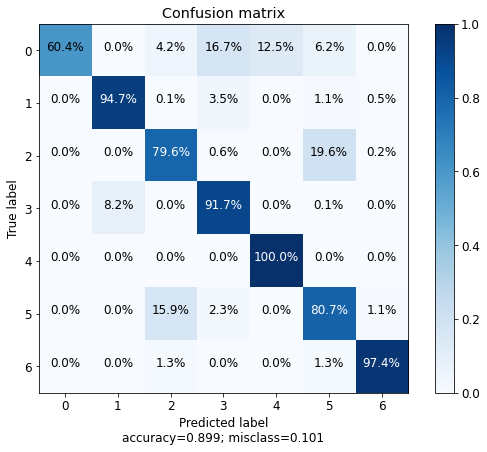

In [25]:
plot_confusion_matrix(cm)

# Reinforce Model
Train the model with person name data set.

In [0]:
name_link = '/content/drive/My Drive/Colab Notebooks/train/name_data.csv'
name_df = pd.read_csv(name_link, dtype = {'sentence': str, 'label': int})
name_df.columns = ['text', 'labels']
name_df[:10]

In [0]:
# Train the model
model.train_model(name_df, eval_df=eval_df)

In [0]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

In [0]:
# get true/predict data value of labels.
predict_tag = model.predict(eval_df['text'])
predict_tag = predict_tag[0]
real_tag = eval_df['labels'].to_numpy()

In [0]:
# show confusion matrix
cm = confusion_matrix(real_tag, predict_tag)
plot_confusion_matrix(cm)

# Example of a prediction

In [0]:
def show_tag(text):
    result, _ = model.predict([text])
    print('{:15} : '.format(text), end="")
    if result == [0]:
        print('그 외')
    elif result == [1]:
        print('상황설명')
    elif result == [2]:
        print('등장인물')
    elif result == [3]:
        print('대사')
    elif result == [4]:
        print('지시사항/감정')
    elif result == [5]:
        print('장소')
    elif result == [6]:
        print('시간')
    elif result == [7]:
        print('시대')


In [28]:
show_tag('HARRY POTER')
show_tag('PALACE')
show_tag('REVERSE ANGLE')
show_tag('Love means never having to say I\'m sorry.')
show_tag('That\'s called pain.')
show_tag('MATCH CUT TO:')
show_tag('FADE IN')
show_tag('FADE OUT')
show_tag('FADE IN:')
show_tag('DISSOLVE TO:')
show_tag('THEOLOGICAL SOCIETY')
show_tag('FATHER GARRET and Angela have retreated to another area for privacy.')
show_tag('JOHN')


HARRY POTER     : 등장인물



PALACE          : 장소



REVERSE ANGLE   : 장소



Love means never having to say I'm sorry. : 대사



That's called pain. : 대사



MATCH CUT TO:   : 그 외



FADE IN         : 그 외



FADE OUT        : 그 외



FADE IN:        : 그 외



DISSOLVE TO:    : 대사



THEOLOGICAL SOCIETY : 장소



FATHER GARRET and Angela have retreated to another area for privacy. : 상황설명



JOHN            : 등장인물
